In [210]:
%matplotlib inline

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from sotodlib import core
from sotodlib.core.metadata import ManifestDb, load_metadata
import sotodlib.io.load_book as lb

from optical_loading import pwv_interp, get_fpa_temps, UXM_dict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
## context for loading data
ctx = core.Context('/so/metadata/lat/contexts/smurf_detsets.yaml')


In [238]:
ufm = "mv14"

start = dt.datetime(2025,3,1, tzinfo=dt.timezone.utc)
end = dt.datetime(2025,4,7, tzinfo=dt.timezone.utc)
obs_list = ctx.obsdb.query(
    f"{end.timestamp()} > timestamp and timestamp > {start.timestamp()} and type=='oper' and subtype=='iv'"
    " and stream_ids_list == 'ufm_{}'".format(ufm)
)
obs_list

ResultSet<[obs_id,timestamp,start_time,stop_time,n_samples,telescope,telescope_flavor,tube_slot,tube_flavor,type,subtype,wafer_count,detector_flavor,duration,az_center,az_throw,el_center,el_throw,roll_center,roll_throw,wafer_slots_list,stream_ids_list], 102 rows>

In [239]:
fields = [
    'p_sat', 'R_n', 'bgmap'
]
def add_iv_info( meta ):
    iv = core.AxisManager( meta.dets )

    for f in fields:
        iv.wrap_new(f, ('dets',))
        iv[f] *= np.nan
    iv_data = lb.load_smurf_npy_data(ctx, meta.obs_info.obs_id, 'iv')

    for d in range( iv_data['nchans']):
        idx = np.where( np.all( [
            meta.det_info.smurf.band == iv_data['bands'][d],
            meta.det_info.smurf.channel == iv_data['channels'][d],
        ], axis=0))[0]
        if len(idx) == 0:
            print( f"Cannot find ({iv_data['bands'][d]},{iv_data['channels'][d]})")
            continue
        idx = idx[0]
        iv.bgmap[idx] = iv_data['bgmap'][d]
        
        if iv.bgmap[idx] not in iv_data['bias_groups']:
            ## iv did not include bias group detector is attached to
            continue
        
        iv.p_sat[idx] = iv_data['p_sat'][d]*1e12
        iv.R_n[idx] = iv_data['R_n'][d]
    meta.wrap("iv", iv)

In [240]:
obs = obs_list[50]

meta = ctx.get_meta( obs )
add_iv_info( meta )


(array([ 10.,   5.,  27.,  28.,  49.,  68.,  78., 132., 183., 121.,  47.,
          5.,   0.,   2.,   0.,   0.,   1.,   1.,   0.,   0.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8,
        5.2, 5.6, 6. , 6.4, 6.8, 7.2, 7.6, 8. ]),
 <BarContainer object of 20 artists>)

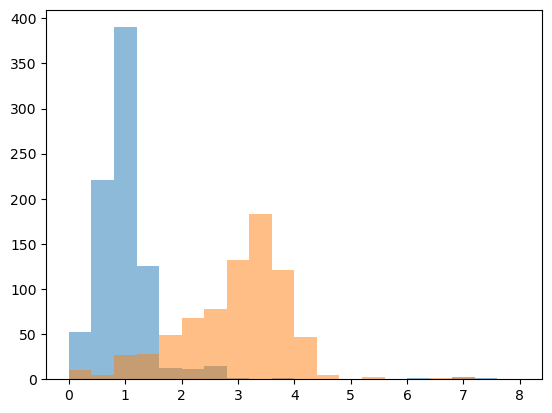

In [241]:
plt.figure()
msk_f090 = np.any([meta.iv.bgmap == x for x in [0,1,4,5,8,9]],axis=0)
msk_f150 = np.any([meta.iv.bgmap == x for x in [2,3,6,7,10,11]],axis=0)

plt.hist( meta.iv.p_sat[msk_f090], range=(0,8), bins=20, alpha=0.5,)
plt.hist( meta.iv.p_sat[msk_f150], range=(0,8), bins=20, alpha=0.5,)


In [242]:
## from above, I know obs_list has only one stream_id in it

singles = []
obs_start = 0
obs_end = len(obs_list)
for i in range(obs_start,obs_end):
    obs = obs_list[i]
    meta = ctx.get_meta( obs )
    add_iv_info( meta )
    singles.append(meta)
x = [m.dets.count for m in singles]
assert min(x) == max(x), "Need to add some additional checks if channel counts are changing"

In [243]:
all_iv_data = core.AxisManager(
    singles[0].dets,
    core.IndexAxis('obs', len(singles)),
)

pwv = pwv_interp()

obs_info = core.AxisManager(all_iv_data.obs)
for f in singles[0].obs_info._fields.keys():
    if f == "obs_id":
        obs_info.wrap_new( f, ('obs',), dtype=f'<U{np.max([len(obs_id) for obs_id in singles[0].obs_info[f]])}')
    else:
        obs_info.wrap_new( f, ('obs',), dtype=type(singles[0].obs_info[f]))
        
#Add pwv
obs_info.wrap_new("pwv", ('obs',), dtype=float)
obs_info.wrap_new("ufm_temp", ('obs',), dtype=float)

fpa_temps = get_fpa_temps(obs_list[obs_start:obs_end])

for m, meta in enumerate(singles):
    for f in singles[0].obs_info._fields.keys():
        obs_info[f][m] = meta.obs_info[f]
        if f == "obs_id":
            obs_info[f][m] = "test"
    obs_info["pwv"][m] = pwv((obs_info["start_time"][m] + obs_info["stop_time"][m])/2)
    obs_info["ufm_temp"][m] = fpa_temps[m]

all_iv_data.wrap('obs_info', obs_info)
all_iv_data.wrap('det_info', singles[0].det_info)
# don't have a focal plane yet
#all_iv_data.wrap('focal_plane', singles[0].focal_plane)

iv_data = core.AxisManager( all_iv_data.dets, all_iv_data.obs)
for f in singles[0].iv._fields.keys():
    iv_data.wrap_new(f, ('dets','obs'), dtype=type(singles[0].iv[f]))
    iv_data[f] *= np.nan

for m, meta in enumerate(singles):
    for f in singles[0].iv._fields.keys():
        iv_data[f][:,m] = meta.iv[f][:]
all_iv_data.wrap('iv', iv_data)

AxisManager(obs_info*[obs], det_info*[dets], iv*[dets,obs], dets:LabelAxis(1737), obs:IndexAxis(102))

(0.0, 10.0)

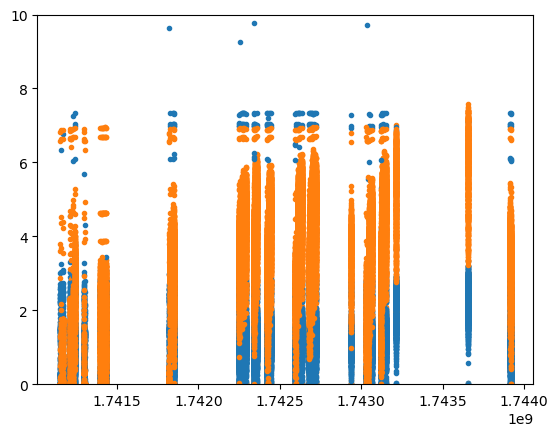

In [244]:
msk_f090 = np.any([meta.iv.bgmap == x for x in [0,1,4,5,8,9]],axis=0)

plt.figure()
for i in range(all_iv_data.dets.count):
    if meta.iv.bgmap[i] in [0,1,4,5,8,9]:
        color='C0'
    elif meta.iv.bgmap[i] in [2,3,6,7,10,11]:
        color='C1'
    else:
        continue
    plt.plot( all_iv_data.obs_info.timestamp, all_iv_data.iv.p_sat[i], '.', color=color)

plt.ylim(0,10)

Text(0, 0.5, 'P_sat (pW)')

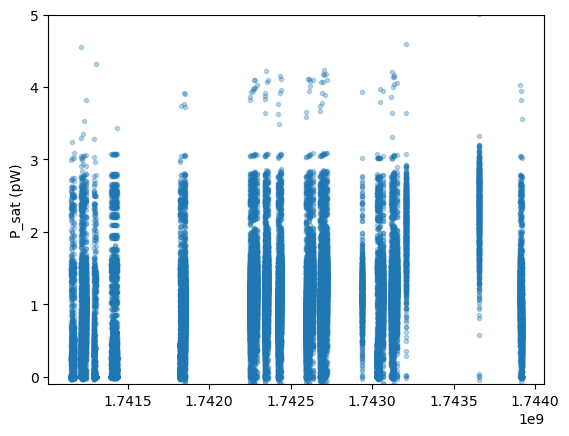

In [245]:
plt.figure()
for i in range(all_iv_data.dets.count):
    if meta.iv.bgmap[i] in [0,1,4,5,8,9]:
        color='C0'
    elif meta.iv.bgmap[i] in [2,3,6,7,10,11]:
        continue
    else:
        continue
    plt.plot( all_iv_data.obs_info.timestamp, all_iv_data.iv.p_sat[i], '.', color=color, alpha=0.3)

plt.ylim(-0.1,5)
plt.ylabel('P_sat (pW)')

In [295]:
lopts_090 = []
lopts_150 = []
for i, psat in enumerate(all_iv_data.iv.p_sat):
    lopt = UXM_dict[ufm]["psat_dark"]- psat + UXM_dict[ufm]["kappa"]*(0.1**3 - obs_info.ufm_temp**3)
    
    if all([np.isnan(item) for item in lopt]):
        continue
    
    if meta.iv.bgmap[i] in [0,1,4,5,8,9]:
        lopts_090.append(lopt)
    elif meta.iv.bgmap[i] in [2,3,6,7,10,11]:
        lopts_150.append(lopt)
lopts_090 = np.array(lopts_090)
lopts_150 = np.array(lopts_150)

In [298]:
lopts_090

array([[2.6737969566619935, 2.5327769467745203, nan, ..., nan, nan, nan],
       [2.6731164882496445, 2.657386630834608, nan, ..., nan, nan, nan],
       [2.6740056327509993, 2.6745837824572174, nan, ..., nan, nan, nan],
       ...,
       [2.672358131806447, 2.303238513426631, nan, ..., nan, nan, nan],
       [2.67269548529192, 2.475665935435757, nan, ..., nan, nan, nan],
       [2.6736441555957637, nan, 2.342011883459269, ..., nan, nan, nan]],
      dtype=object)

In [296]:
plt.scatter(obs_info.pwv/np.sin(obs_info.el_center* np.pi / 180.), np.nanmean(lopts_090, axis = 0))

ZeroDivisionError: division by zero

In [266]:
np.nanmean(lopts_090, axis = 1)

array([1.7787567564352427, 2.2926592067597764, 1.6928190755127295,
       1.6012609428747113, 1.241333281819148, 1.9249249105493764,
       1.6299218973270984, 1.253946909954118, 1.7341534152081528,
       1.491785078640671, 1.474097006399317, 1.9412478174141223,
       1.4955575267761345, 1.596021387004884, 2.1467134011974656,
       1.3265319536606468, 1.7634224011737971, 1.4437640827115337,
       1.6312615084729352, -0.08783913466149831, -0.992572407025364,
       0.9689747334995695, 1.7073262283336452, 1.7111143265183189,
       1.7247809726682872, 0.3528696223246486, 2.050190686255323,
       1.495342995065671, 1.0839225342325105, 1.5839563354480837,
       1.6354228964039785, 1.8720921495620215, 1.6547693498415665,
       2.048184055344257, 1.6919890198636793, 1.3663601436370478,
       1.8951788293305711, 1.3544308573546004, 1.6649911493905747,
       1.7556271273554684, 1.4250144674185856, 1.0545691643478283,
       1.2355840201133133, 1.4633422743255273, 1.5382854731504627,
 

In [250]:
from so3g.proj import quat

fp = obs_info.focal_plane
bs = obs_info.boresight

qbs = quat.rotation_lonlat(0, bs.el[0], bs.roll[0])
qdets = qbs * quat.rotation_xieta(fp.xi, fp.eta)

az_det, el_det, _ = quat.decompose_lonlat(qdets)
az_det = -az_det

AttributeError: focal_plane